# Bitcoin Trading Bot

## Problem Statement


In the rapidly evolving world of cryptocurrency, Bitcoin remains a dominant player, and its upcoming halving event this year is poised to have significant effects on its market dynamics. This event, which reduces the rewards for Bitcoin miners by half, is known to historically impact the supply and volatility of Bitcoin. University students, who are often tech-savvy and eager to invest or trade in emerging markets, may see this as an opportunity to engage with the Bitcoin market. However, given their typically limited financial resources and experience, students face heightened risks and challenges in effectively navigating the volatile Bitcoin market.

Our project aims to address this problem by developing a Bitcoin trading bot that leverages machine learning to predict the next day’s closing price of Bitcoin, with a focus on providing reliable, actionable insights to university students. By helping them make informed trading decisions, we strive to support students in achieving financial success while minimizing the risks associated with Bitcoin's volatility and the uncertainty around the halving event. Through targeted educational resources and user-friendly tools, our solution empowers university students to confidently participate in the cryptocurrency market.

## Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mplfinance as mpf
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

In [2]:
#Setting date as index of rows
df = pd.read_csv("btc_2015_2024.csv")
df['date']=pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df=df.set_index('date')
df.head()


,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,sma_50,ema_50,sma_100,ema_100,macd,bollinger,TrueRange,atr_7,atr_14,next_day_close,year
date,,,,,,,,,,,,,,,,,,,,
2015-01-02,314.079010,315.838989,313.565002,315.032013,7860650.0,100.000000,100.000000,-66.666667,-66.666667,314.640503,314.648333,314.640503,314.644418,0.017568,314.640503,2.273987,4.193073,4.275997,281.082001,2015
2015-01-03,314.846008,315.149994,281.082001,281.082001,33054400.0,1.938583,2.096744,-100.000000,-100.000000,303.454336,303.009081,303.454336,303.232458,-1.030403,303.454336,34.067993,15.719617,14.951008,264.195007,2015
2015-01-04,281.145996,287.230011,257.612000,264.195007,55629100.0,1.235506,1.375421,-110.693896,-110.693896,293.639503,292.715747,293.639503,293.178382,-2.091487,293.639503,29.618011,20.033779,19.034849,274.473999,2015
2015-01-05,265.084015,278.341003,265.084015,274.473999,43962800.0,21.462825,19.523695,-76.487357,-76.487357,289.806403,288.769813,289.806403,289.286389,-2.215008,289.806403,14.145996,18.468441,17.907070,286.188995,2015
2015-01-06,274.610992,287.553009,272.696014,286.188995,23245700.0,38.272356,34.350787,-37.070244,-37.070244,289.203501,288.295540,289.203501,288.744005,-1.746686,289.203501,14.856995,17.613461,17.300126,294.337006,2015


In [3]:
#Plotting a candlestick to analyze general movement of bitcoin
import plotly.graph_objects as go
def candle_chart(data,label):

    candlestick = go.Figure(data = [go.Candlestick(x=data.index,
                                                   open = data['open'], 
                                                   high = data['high'], 
                                                   low = data['low'], 
                                                   close = data['close'])])
    candlestick.update_xaxes(title_text = 'Time',
                             rangeslider_visible = True)

    candlestick.update_layout(
    title = {
            'text': '{:} Candelstick Chart'.format(label),
            "y":0.8,
            "x":0.5,
            'xanchor': 'center',
            'yanchor': 'top'})

    candlestick.update_yaxes(title_text = 'Price in USD', ticksuffix = '$')
    return candlestick

%matplotlib inline
candle=candle_chart(df, label="BTC Price")
candle.show()

In [4]:
#Dropping the 'year' column
bitcoinData = df.drop(columns = ['year'])
bitcoinData.head()

,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,sma_50,ema_50,sma_100,ema_100,macd,bollinger,TrueRange,atr_7,atr_14,next_day_close
date,,,,,,,,,,,,,,,,,,,
2015-01-02,314.079010,315.838989,313.565002,315.032013,7860650.0,100.000000,100.000000,-66.666667,-66.666667,314.640503,314.648333,314.640503,314.644418,0.017568,314.640503,2.273987,4.193073,4.275997,281.082001
2015-01-03,314.846008,315.149994,281.082001,281.082001,33054400.0,1.938583,2.096744,-100.000000,-100.000000,303.454336,303.009081,303.454336,303.232458,-1.030403,303.454336,34.067993,15.719617,14.951008,264.195007
2015-01-04,281.145996,287.230011,257.612000,264.195007,55629100.0,1.235506,1.375421,-110.693896,-110.693896,293.639503,292.715747,293.639503,293.178382,-2.091487,293.639503,29.618011,20.033779,19.034849,274.473999
2015-01-05,265.084015,278.341003,265.084015,274.473999,43962800.0,21.462825,19.523695,-76.487357,-76.487357,289.806403,288.769813,289.806403,289.286389,-2.215008,289.806403,14.145996,18.468441,17.907070,286.188995
2015-01-06,274.610992,287.553009,272.696014,286.188995,23245700.0,38.272356,34.350787,-37.070244,-37.070244,289.203501,288.295540,289.203501,288.744005,-1.746686,289.203501,14.856995,17.613461,17.300126,294.337006


In [5]:
# Create short simple moving average over the short window
bitcoinData['short_mavg'] = bitcoinData['close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
bitcoinData['long_mavg'] = bitcoinData['close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
bitcoinData['signal'] = np.where(bitcoinData['short_mavg'] > bitcoinData['long_mavg'], 1, 0)

bitcoinData.tail(n=10)

,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,sma_50,...,ema_100,macd,bollinger,TrueRange,atr_7,atr_14,next_day_close,short_mavg,long_mavg,signal
date,,,,,,,,,,,,,,,,,,,,,
2024-02-29,62499.183594,63585.644531,60498.730469,61198.382813,6.549661e+10,82.444436,80.651953,112.845315,206.401046,46578.032891,...,44510.887771,3421.157344,52601.613086,3086.914062,2675.298535,2124.654647,62440.632813,54477.626172,46281.467318,1
2024-03-01,61168.062500,63155.101563,60802.527344,62440.632813,4.018637e+10,84.383498,82.051072,85.572355,151.130342,46899.473828,...,44865.932227,3758.938895,53335.080860,2352.574219,2629.195061,2140.934617,62029.847656,55493.201953,46586.022331,1
2024-03-02,62431.652344,62458.699219,61657.289063,62029.847656,2.388847e+10,80.934728,79.991154,63.491506,115.870362,47283.007422,...,45205.811741,3947.976464,54021.877344,801.410156,2368.082932,2045.254298,63167.371094,56512.268750,46870.553646,1
2024-03-03,62031.578125,63230.210938,61435.023438,63167.371094,2.625381e+10,83.158453,81.384834,62.751883,101.676750,47689.507188,...,45561.486184,4141.834247,54682.334766,1795.187500,2286.240728,2027.392384,68330.414063,57698.508594,47209.206901,1
2024-03-04,63137.003906,68537.031250,62386.519531,68330.414063,7.067047e+10,89.588769,86.112891,176.941842,127.173288,48220.190078,...,46012.356043,4658.383410,55611.733399,6150.511719,2838.279441,2321.900908,63801.199219,59458.355078,47611.715104,1
2024-03-05,68341.054688,69170.625000,59323.910156,63801.199219,1.028029e+11,64.416956,69.448775,59.907457,82.236455,48645.974688,...,46364.610363,4648.695293,56210.458594,9846.714844,3839.484498,2859.387618,66106.804688,60681.364844,47939.023568,1
2024-03-06,63776.050781,67637.929688,62848.671875,66106.804688,6.875023e+10,69.505477,72.378996,85.488532,87.939982,49105.011875,...,46755.544904,4772.051246,56918.871094,4789.257813,3975.166400,2997.235489,66925.484375,62118.721485,48307.650391,1
2024-03-07,66099.742188,68029.921875,65655.531250,66925.484375,4.698954e+10,71.210976,73.356192,100.671004,95.339598,49588.668516,...,47154.949646,4879.623079,57657.135156,2374.390625,3746.484147,2952.746570,68300.093750,63359.029688,48690.690169,1
2024-03-08,66938.093750,70083.054688,66230.453125,68300.093750,5.920288e+10,74.053595,74.958176,109.722723,108.701098,50129.429219,...,47573.665371,5017.950214,58488.990039,3852.601563,3761.643778,3017.021926,68498.882813,64480.501953,49046.183334,1


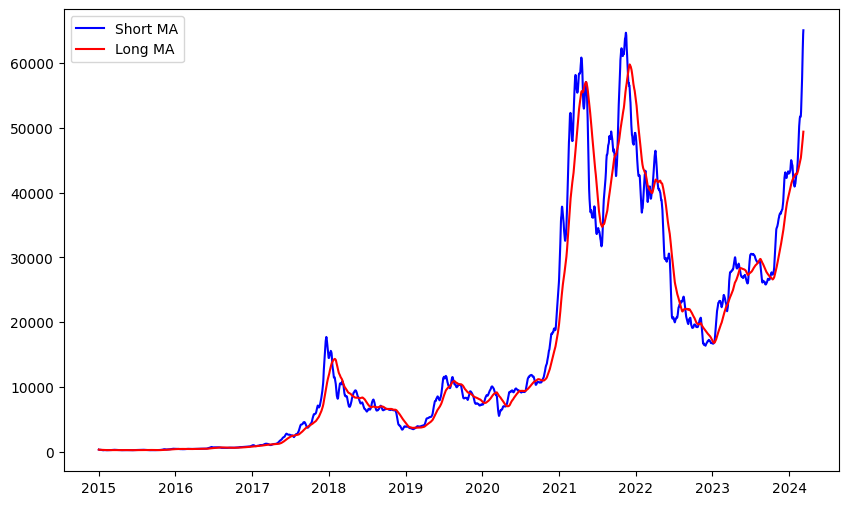

In [6]:
graph_df =bitcoinData.loc["2015-01-02":"2024-03-09"].copy()
plt.figure(figsize=(10, 6))
plt.plot(graph_df.index, graph_df['short_mavg'], label='Short MA', color='blue')
plt.plot(graph_df.index, graph_df['long_mavg'], label='Long MA', color='red')
plt.legend()

In [7]:
#Checking the data size 
print("Data type : ", type(bitcoinData))
print("Data dims : ", bitcoinData.shape)

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (3355, 22)


In [8]:
#Checking the existing variables
print(bitcoinData.dtypes)

open              float64
high              float64
low               float64
close             float64
volume            float64
rsi_7             float64
rsi_14            float64
cci_7             float64
cci_14            float64
sma_50            float64
ema_50            float64
sma_100           float64
ema_100           float64
macd              float64
bollinger         float64
TrueRange         float64
atr_7             float64
atr_14            float64
next_day_close    float64
short_mavg        float64
long_mavg         float64
signal              int32
dtype: object


In [9]:
#Checking the type of the variables
bitcoinData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3355 entries, 2015-01-02 to 2024-03-09
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open            3355 non-null   float64
 1   high            3355 non-null   float64
 2   low             3355 non-null   float64
 3   close           3355 non-null   float64
 4   volume          3355 non-null   float64
 5   rsi_7           3355 non-null   float64
 6   rsi_14          3355 non-null   float64
 7   cci_7           3355 non-null   float64
 8   cci_14          3355 non-null   float64
 9   sma_50          3355 non-null   float64
 10  ema_50          3355 non-null   float64
 11  sma_100         3355 non-null   float64
 12  ema_100         3355 non-null   float64
 13  macd            3355 non-null   float64
 14  bollinger       3355 non-null   float64
 15  TrueRange       3355 non-null   float64
 16  atr_7           3355 non-null   float64
 17  atr_14         

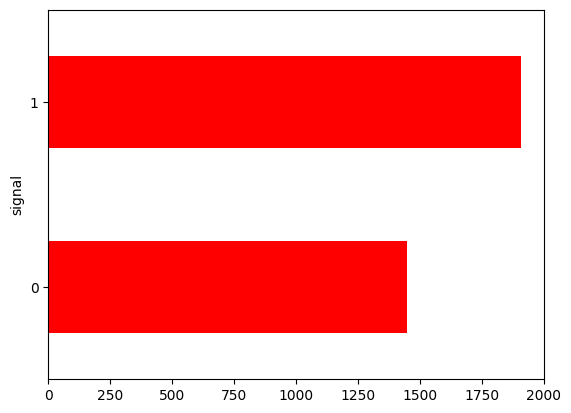

In [10]:
fig = plt.figure()
plot = bitcoinData.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

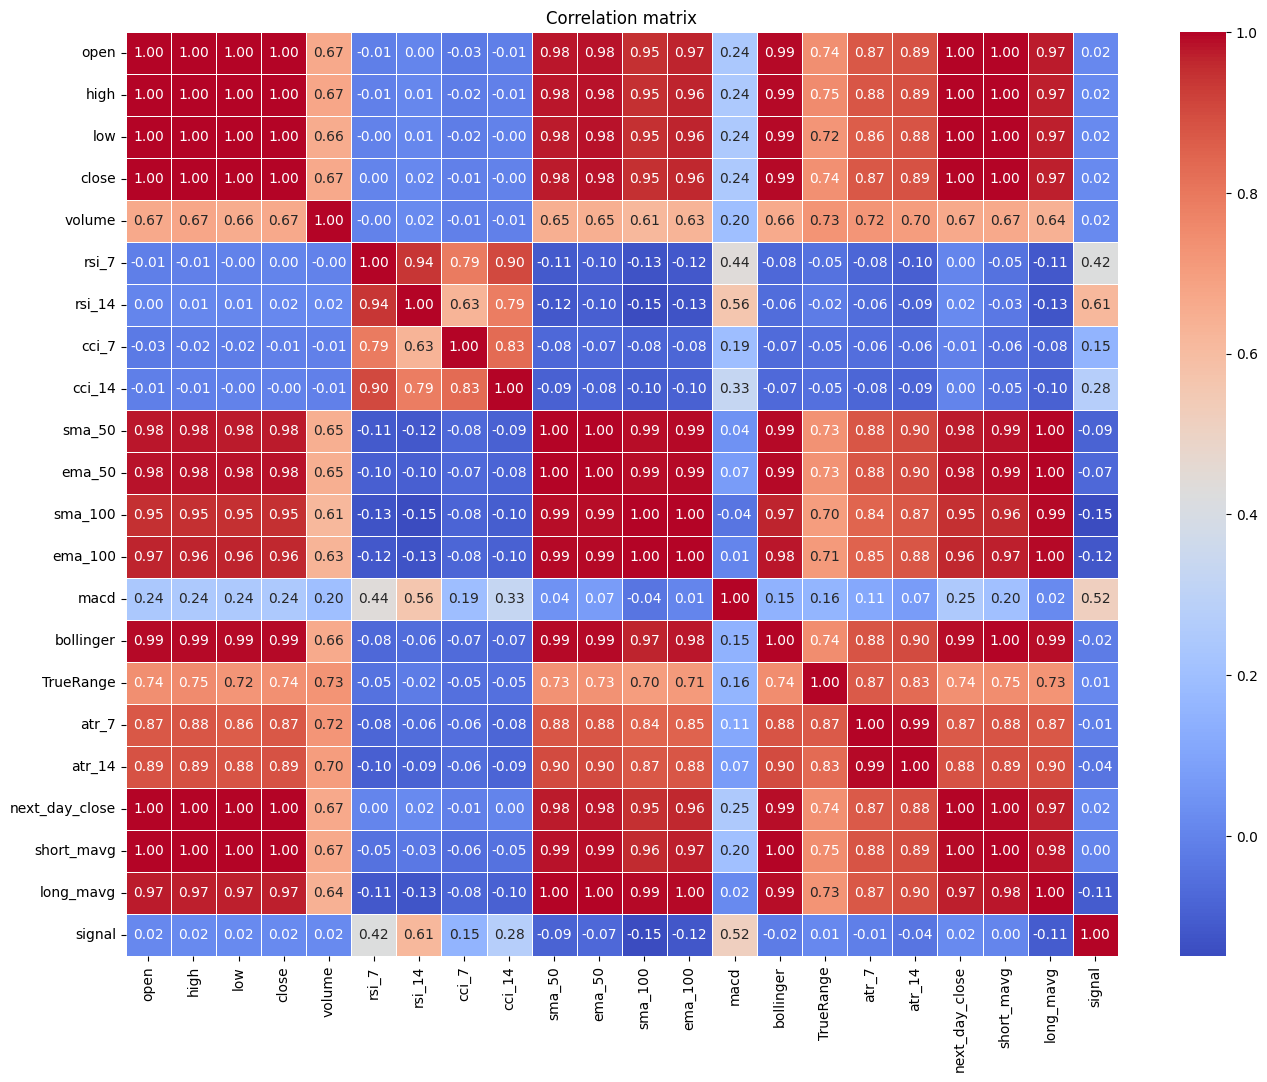

In [11]:
#Displaying the heatmap for correlation matrix
correlation_matrix = bitcoinData.corr()
plt.figure(figsize=(16,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5, fmt='.2f')
plt.title("Correlation matrix")
plt.show()

In [12]:
bitcoinData = bitcoinData.drop(columns=['open','high','low','short_mavg','long_mavg','close','next_day_close','sma_50','sma_100','ema_50','ema_100'])


In [13]:
bitcoinData.sample(n=10)

,volume,rsi_7,rsi_14,cci_7,cci_14,macd,bollinger,TrueRange,atr_7,atr_14,signal
date,,,,,,,,,,,
2022-04-20,2.781953e+10,49.655317,46.878644,132.730618,20.321238,-704.705248,42496.023242,1165.203125,1362.371937,1454.774021,0
2016-01-31,3.789430e+07,31.558251,38.174048,-106.994818,-130.828982,-11.943839,394.446602,12.511994,14.510780,15.817521,0
2019-12-03,1.479749e+10,36.587105,36.643778,-82.592166,-38.322006,-338.711898,7750.656934,189.501953,321.725398,328.390900,0
2015-12-11,1.109440e+08,90.200325,79.406727,148.907801,165.612893,24.223268,371.613550,36.656982,18.714304,18.047503,1
2018-01-25,8.873170e+09,38.247467,40.300160,-18.203337,-49.743031,-978.901678,13138.055029,728.299804,1326.915580,1451.943395,0
2019-06-10,1.868928e+10,48.962261,52.952664,18.551721,-62.834331,177.923480,8195.536401,445.178711,381.575227,385.776773,1
2022-08-26,4.232679e+10,22.465540,32.605120,-178.404001,-87.315918,-523.876389,22776.538086,1605.425781,866.196385,883.603968,0
2017-12-31,1.213630e+10,43.794705,48.181573,-72.669807,-75.965143,205.846083,16042.204981,1621.800782,1851.470091,1759.282766,1
2021-10-15,5.178008e+10,83.006658,74.488841,188.654951,148.005383,3462.530119,50960.383399,5888.984375,3042.672714,2785.906852,1


# Machine Learning Models

In [14]:
# split out validation dataset for the end
subset_dataset= bitcoinData.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, bitcoinData.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

In [15]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'precision'

In [16]:
# spot check the algorithms
models = []
models.append(('Logistic Regression', LogisticRegression(n_jobs=-1)))
# Boosting methods
models.append(('Gradient Boosting Classifier', GradientBoostingClassifier()))
# Bagging methods
models.append(('Random Forest Classifier', RandomForestClassifier(n_jobs=-1)))

In [17]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    
    name_width = 28
    precision_width = 10  
    std_dev_width = 10  
    
    # Print the message with aligned columns
    msg = f"{name:<{name_width}} | Precision: {cv_results.mean():^{precision_width}.6f} | Standard Deviation: {cv_results.std():<{std_dev_width}.6f}"
    print(msg)

Logistic Regression          | Precision:  0.691351  | Standard Deviation: 0.171008  
Gradient Boosting Classifier | Precision:  0.946459  | Standard Deviation: 0.018293  
Random Forest Classifier     | Precision:  0.957602  | Standard Deviation: 0.016411  


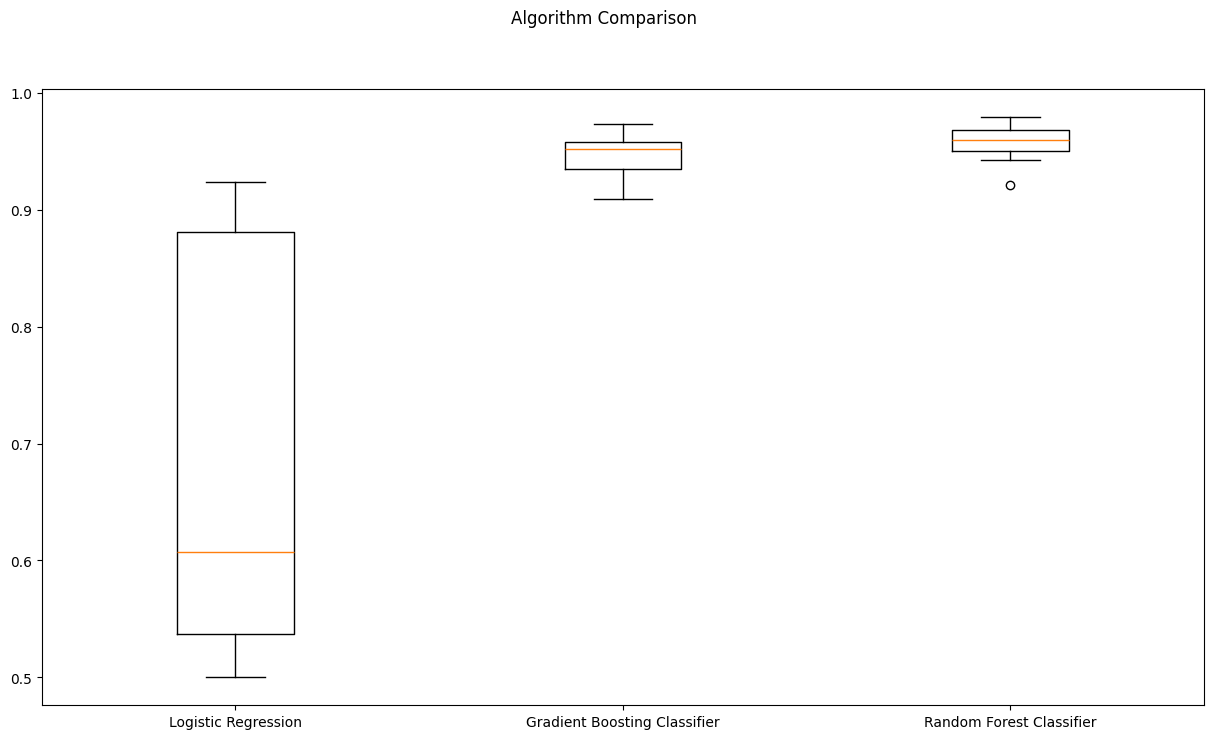

In [18]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

# Parameter Tuning

In [19]:
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform.
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators.
    The maximum depth limits the number of nodes in the tree.
    Tune this parameter for best performance; the best value depends on the interaction of the input variables
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split.
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

'''
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.952328 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}
#5 0.931700 (0.023537) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#6 0.927396 (0.022191) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#3 0.948304 (0.018682) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#2 0.950679 (0.017498) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.924192 (0.022245) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#7 0.926228 (0.021670) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.947910 (0.019378) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#1 0.952328 (0.020219) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


# Evaluating Model's Performance

In [20]:
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=20 ,max_depth=10,n_jobs=-1)
#model = LogisticRegression()

model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=20, n_jobs=-1)

In [21]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print("Accuracy score:", accuracy_score(Y_validation, predictions))
print("Confusion matrix:\n", confusion_matrix(Y_validation, predictions))

Accuracy score: 0.9418777943368107
Confusion matrix:
 [[283  18]
 [ 21 349]]


<Axes: xlabel='Predicted', ylabel='Actual'>

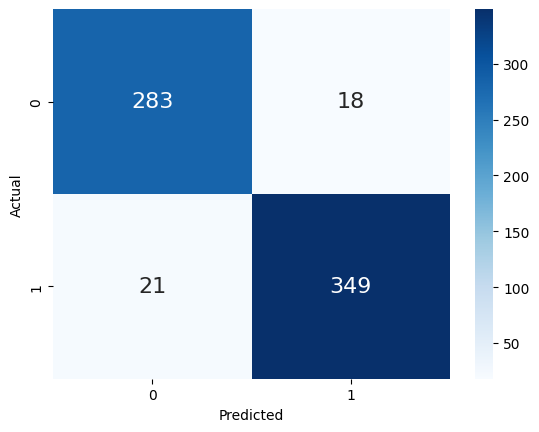

In [22]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", fmt = 'd', annot=True,annot_kws={"size": 16})

## Visualisation

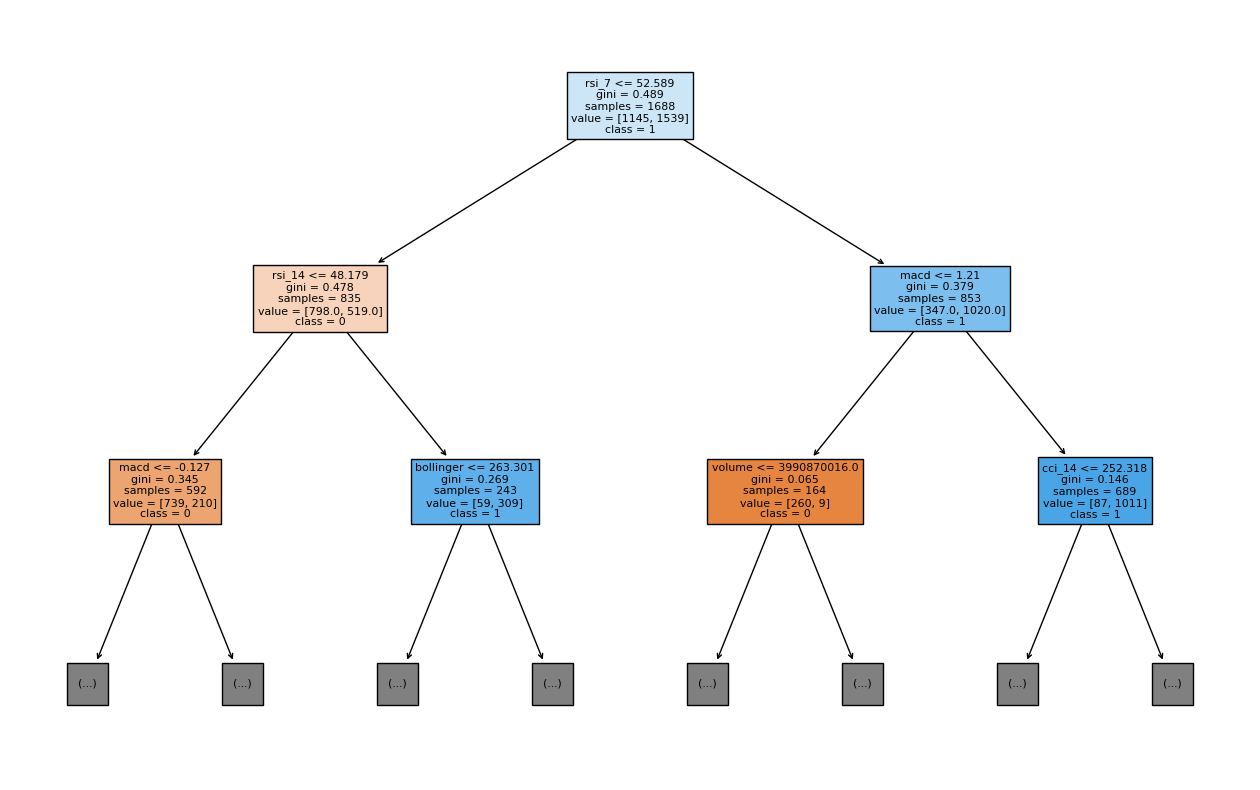

In [37]:
plt.figure(figsize=(16, 10))
tree.plot_tree(model.estimators_[0], feature_names=X_train.columns, class_names=['0', '1'], filled=True, max_depth=2)
plt.show()

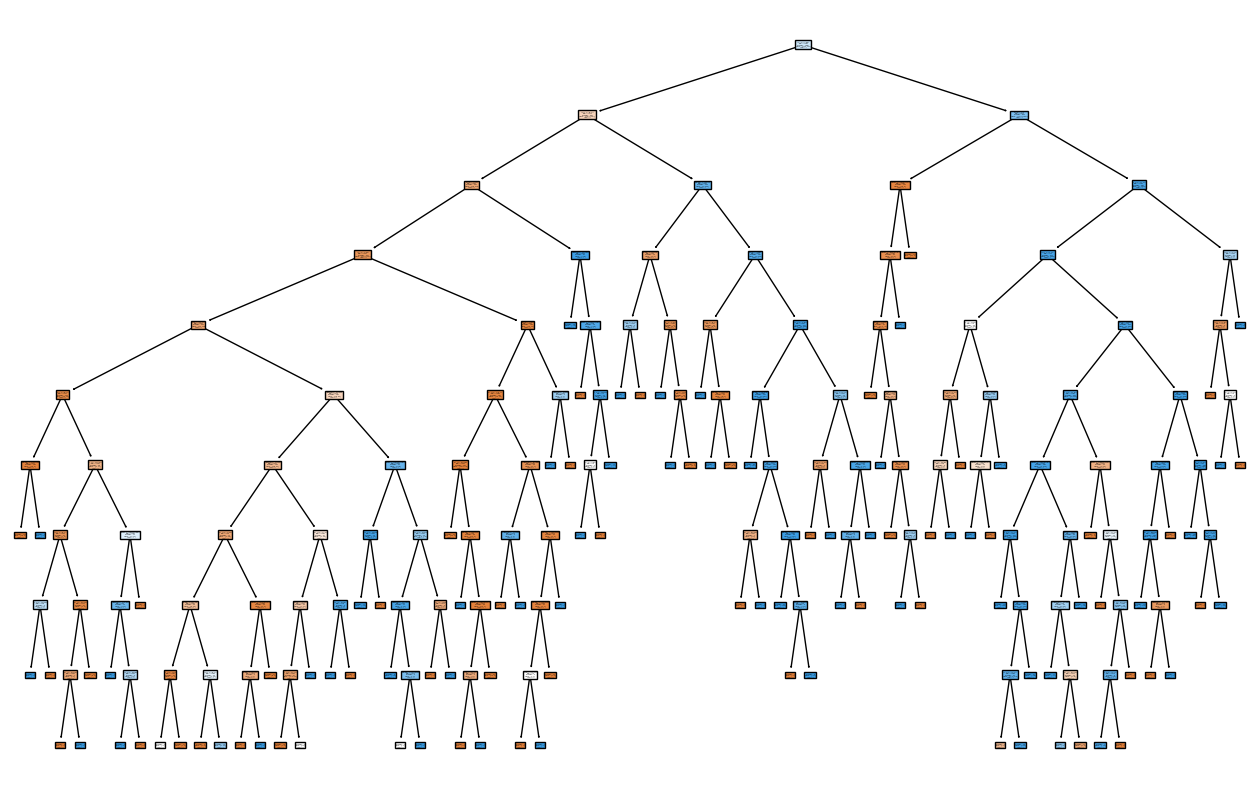

In [38]:
plt.figure(figsize=(16, 10))
tree.plot_tree(model.estimators_[0], feature_names=X_train.columns, class_names=['0', '1'], filled=True)
plt.show()

# Feature Importance

Text(0.5, 0, 'Variable Importance')

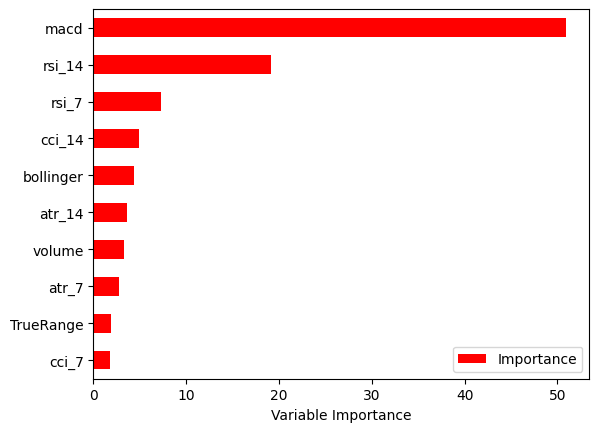

In [24]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')